In [9]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import v2 as transforms
from torchinfo import summary

device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Creating data transforms
data_transforms = transforms.Compose([
    transforms.PILToTensor(),
    transforms.ToDtype(torch.float32, scale=True)
])

batch_size = 32
num_workers = os.cpu_count()

# Creating the dataset and the dataloader
train_dataset = datasets.MNIST(root='./data/', train=True, transform=data_transforms, download=True)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, pin_memory=True)

test_dataset = datasets.MNIST(root='./data/', train=False, transform=data_transforms, download=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, pin_memory=True)

In [5]:
class DenoisingAutoencoder(nn.Module):
  def __init__(self):
    super().__init__()

    # Encoder
    self.encoder = nn.Sequential(
        nn.Conv2d(1, 16, 3, 1, 1),  # Output --> [16, 28, 28]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # Output --> [16, 14, 14]
        nn.Conv2d(16, 32, 3, 1),  # Output --> [32, 12, 12]
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)),  # Output --> [32, 6, 6]
        nn.Conv2d(32, 64, 6)  # Output --> [64, 1, 1]
    )

    # Decoder
    self.decoder = nn.Sequential(
        nn.ConvTranspose2d(64, 32, 7),  # Output --> [32, 7, 7]
        nn.ReLU(),
        nn.ConvTranspose2d(32, 16, 3, 2, 1, output_padding=1),  # Output --> [16, 14, 14]
        nn.ReLU(),
        nn.ConvTranspose2d(16, 1, 3, 2, 1, output_padding=1), # Output --> [1, 28, 28]
        nn.Sigmoid()
    )

  def forward(self, x):
    return self.decoder(self.encoder(x))

In [6]:
model = DenoisingAutoencoder().to(device)
summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]             160
              ReLU-2           [-1, 16, 28, 28]               0
         MaxPool2d-3           [-1, 16, 14, 14]               0
            Conv2d-4           [-1, 32, 12, 12]           4,640
              ReLU-5           [-1, 32, 12, 12]               0
         MaxPool2d-6             [-1, 32, 6, 6]               0
            Conv2d-7             [-1, 64, 1, 1]          73,792
   ConvTranspose2d-8             [-1, 32, 7, 7]         100,384
              ReLU-9             [-1, 32, 7, 7]               0
  ConvTranspose2d-10           [-1, 16, 14, 14]           4,624
             ReLU-11           [-1, 16, 14, 14]               0
  ConvTranspose2d-12            [-1, 1, 28, 28]             145
          Sigmoid-13            [-1, 1, 28, 28]               0
Total params: 183,745
Trainable params:

In [7]:
# Specifying loss function and optimizer
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [10]:
# Training
n_epochs = 5
noise_factor = 0.5

for epoch in range(1, n_epochs+1):
  train_loss = 0

  for images, labels in train_dataloader:
    # Adding 0.5 * random value to each pixel value in image.
    noisy_imgs = images + noise_factor * torch.randn(*images.shape)
    # Clipping values between 0 and 1.
    noisy_imgs = np.clip(noisy_imgs, 0., 1.)
    # Move to target device
    noisy_imgs = noisy_imgs.to(device)

    # Get predictions from model and calculate loss
    output = model(noisy_imgs)
    loss = loss_fn(output, images)

    # Adjust the weights
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Add loss to train_loss for avg loss
    train_loss += loss.item()*images.size(0)

  train_loss /= len(train_dataloader)
  print("Epochs: [{}/{}] | Train Loss: {:.4f}".format(epoch, n_epochs, train_loss))


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epochs: [1/5] | Train Loss: 1.0340
Epochs: [2/5] | Train Loss: 0.4688
Epochs: [3/5] | Train Loss: 0.4164
Epochs: [4/5] | Train Loss: 0.3936
Epochs: [5/5] | Train Loss: 0.3798


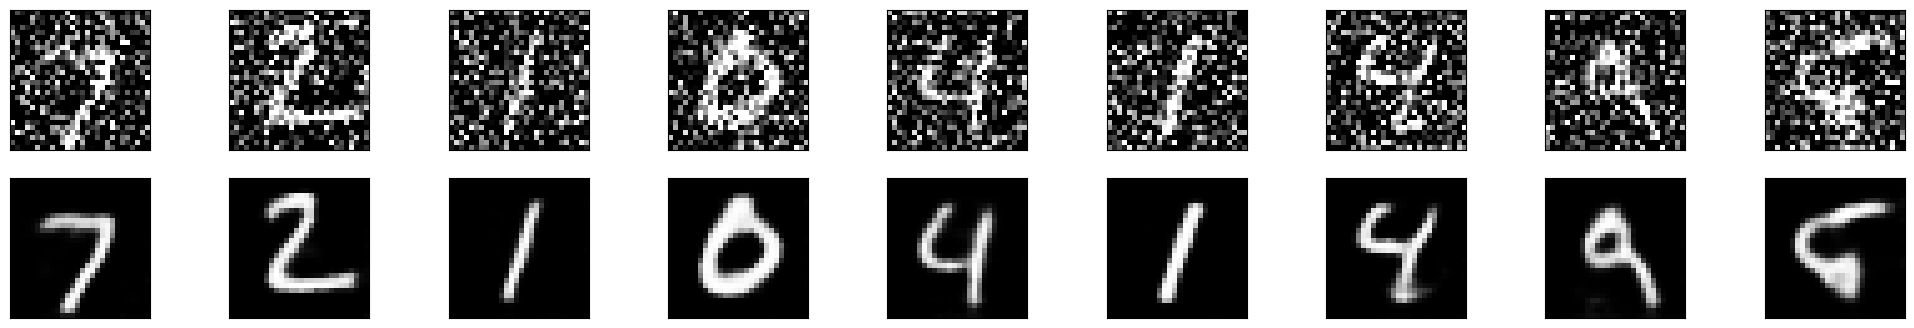

In [15]:
# Visualizing the results
images, labels = next(iter(test_dataloader))

model.eval()
with torch.inference_mode():
  # Add noise to images
  noisy_imgs = images + noise_factor * torch.randn(*images.shape)
  noisy_imgs = np.clip(noisy_imgs, 0., 1.)

  # Get outputs
  output = model(noisy_imgs)
  output = output.view(images.size(0), 1, 28, 28)

  # Converting to ndarray
  noisy_imgs = noisy_imgs.numpy()
  output = output.detach().numpy()

  # Plot the first 10 input images, then reconstructed images
  fig, ax = plt.subplots(2, 9, sharex=True, sharey=True, figsize=(25,4))

  # Noisy images on top row, reconstructed on bottom.
  for noisy_imgs, row in zip([noisy_imgs, output], ax):
    for img, ax in zip(noisy_imgs, row):
      ax.imshow(np.squeeze(img), cmap='gray')
      ax.get_xaxis().set_visible(False)
      ax.get_yaxis().set_visible(False)